In [81]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


In [103]:
# get a sub section of a 2d numpy array with periodic boundary conditions
def get_section(img,x,y,width,height):
    x,y,width,height = int(x),int(y),int(width),int(height)
    # ensure width and height are less than the image size
    assert width <= img.shape[0]
    assert height <= img.shape[1]
    # repeat the image in x and y direction
    x = x + img.shape[0]
    y = y + img.shape[1]
    img = np.tile(img,(3,3))
    # get the sub section
    return img[x-width//2:x+width//2,y-height//2:y+height//2]

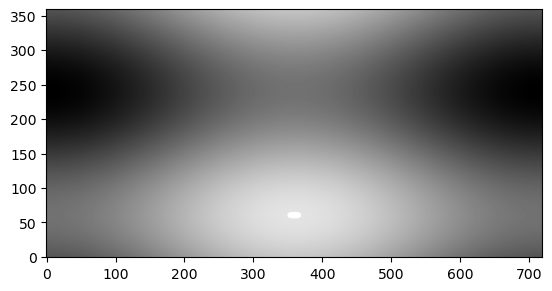

In [156]:
# Arena parameters
world_radius = 10 # in cm
world_local_resolution = 0.1 # in cm
world_angular_resolution = 0.5 # in degrees

# Sun parameters
sun_intensity = 1.0 # in [0, 1]
sun_azimuth = 180 # in degrees
sun_elevation = 30 # in degrees
sun_diameter = 5 # in degrees

# Sky parameters
sky_azimuth = sun_azimuth # in degrees
sky_elevation = sun_elevation # in degrees
sky_min_intensity = 0.5 # in [0, 1]
sky_max_intensity = 0.9 # in [0, 1]

# Generate sky
sky = np.zeros((int(360/world_angular_resolution), int(180/world_angular_resolution)))
for i,x in enumerate(range(int(360/world_angular_resolution))):
    for j,y in enumerate(range(int(180/world_angular_resolution))):
        sky[i, j] = (np.cos(np.deg2rad(x*world_angular_resolution-sky_azimuth))+np.cos(np.deg2rad(-2*sky_elevation+2*y*world_angular_resolution)))/2
sky = sky * (sky_max_intensity - sky_min_intensity) + sky_min_intensity

# add sun
sun_x = int(sun_azimuth/world_angular_resolution)
sun_y = int(sun_elevation/world_angular_resolution)
sun_diameter = int(sun_diameter/world_angular_resolution)
for x in range(sun_x-sun_diameter, sun_x+sun_diameter):
    for y in range(sun_y-sun_diameter, sun_y+sun_diameter):
        if np.sqrt((x-sun_x)**2 + ((y-sun_y)*2)**2) > sun_diameter:
            continue

        if y >= 0:
            y = y % sky.shape[1]
            sky[x, y] = sun_intensity
        else:
            continue


# Plot sky with lower corner as origin
plt.imshow(sky.T, cmap='gray', origin='lower')
plt.show()

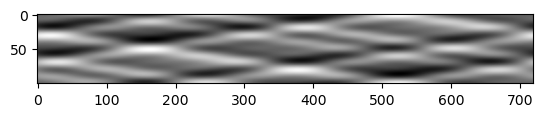

In [171]:
# Wall parameters
wall_height = 10
wall_x_size = int(360/world_angular_resolution)
wall_y_size = int(wall_height/world_local_resolution)

# Wall pattern parameters (perlin noise)
wall_pattern_detail = 5
wall_pattern_seed = 1234
np.random.seed(wall_pattern_seed)
wall_amp_coeffs = np.random.randn(wall_pattern_detail)
wall_phase_coeffs = np.random.uniform(0, 2*np.pi, (wall_pattern_detail,2))
wall_min_intensity = 0.25
wall_max_intensity = 0.75
wall_params = (wall_x_size, wall_y_size, wall_amp_coeffs, wall_phase_coeffs, wall_min_intensity, wall_max_intensity)

# Generate 2d fourier pattern
def fourier_noise_2d(x, y, params):
    x_scale, y_scale, amp_coeffs, phase_coeffs, mins, maxs = params
    total = 0
    for i in range(len(amp_coeffs)):
        total += amp_coeffs[i] * np.cos(2*np.pi*(i+1)*x/x_scale+phase_coeffs[i,0]) * np.cos(2*np.pi*(i+1)*y/y_scale+phase_coeffs[i,1])
    return total / np.sum(np.abs(amp_coeffs)) * (maxs - mins) + mins


# Generate wall pattern
wall_pattern = np.zeros((wall_x_size, wall_y_size))
for x in range(wall_x_size):
    for y in range(wall_y_size):
        wall_pattern[x, y] = fourier_noise_2d(x, y, wall_params)

# Plot wall pattern
plt.imshow(wall_pattern.T, cmap='gray')
plt.show()

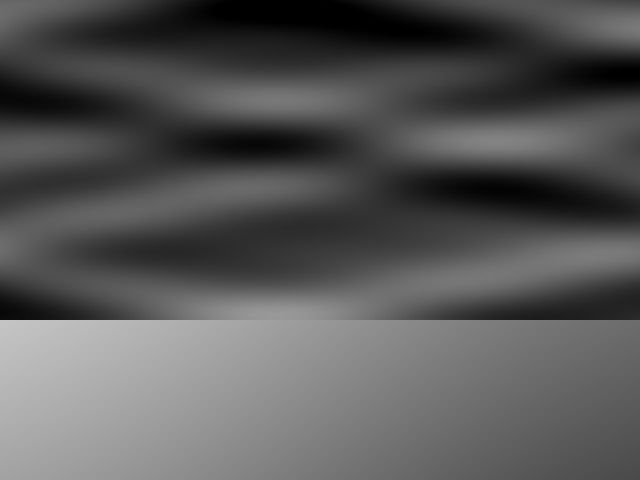

In [174]:
# Camera parameters
camera_height = 0
camera_x_fov = 120
camera_y_fov = 60
camera_x_resolution = 640
camera_y_resolution = 480
camera_phi = 270
camera_theta = 10

# Generate camera view
camera_view = np.zeros((camera_x_resolution, camera_y_resolution))
# get sky
sky_scene = get_section(sky, camera_phi/world_angular_resolution, camera_theta/world_angular_resolution, camera_x_fov/world_angular_resolution, camera_y_fov/world_angular_resolution)
# resize sky to camera resolution using bilinear interpolation in pillow
sky_scene = Image.fromarray(sky_scene[:,::-1].T*255).convert("L")
sky_scene = sky_scene.resize((camera_x_resolution, camera_y_resolution), Image.BILINEAR)

# get wall
wall_distance = 10
upward_angle = np.rad2deg(np.arctan((wall_height-camera_height)/wall_distance))
downward_angle = np.rad2deg(np.arctan(camera_height/wall_distance))
wall_section = get_section(
    wall_pattern,
    camera_phi/world_angular_resolution,
    wall_y_size//2,
    camera_x_fov/world_angular_resolution,
    wall_pattern.shape[1])
# resize wall to part of camera resolution using bilinear interpolation in pillow
wall_section = Image.fromarray(wall_section[:,::-1].T*255).convert("L")
wall_section = wall_section.resize((camera_x_resolution, int((upward_angle+downward_angle)/camera_y_fov*camera_y_resolution)), Image.BILINEAR)

# combine sky and wall
sky_scene.paste(wall_section, (0, int((camera_theta+camera_y_fov/2-upward_angle)/camera_y_fov*camera_y_resolution)))
sky_scene


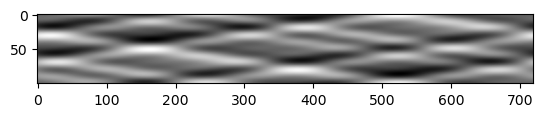